In [1]:
import warnings
import pandas as pd
import numpy as np
import pickle as pkl
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import populate

In [2]:
original = populate.load_elo_data()
original

,Participant #,Test_Date,Question id,Question_en,Answer,Novelty,Feasibility,Value,W_Novelty,L_Novelty,W_Feasibility,L_Feasibility,W_Value,L_Value,NG_NOVELTY,NG_FEASIBILITY,NG_VALUE,English,Question_ja
0,10,2021-12-23T04:04:27,0,Brick,粉砕,1591,1609,1559,7,8,10,9,5,10,1,0,5,Brick,レンガ
1,10,2021-12-23T04:04:27,1,Umbrella,貯水,1615,1610,1617,9,7,10,9,8,6,2,0,7,Umbrella,傘
2,10,2021-12-23T04:04:27,2,Ketchup,入浴剤,1607,1574,1592,11,10,11,14,7,8,4,1,11,Ketchup,ケチャップ
3,10,2021-12-23T04:04:27,3,Rubber band,溶解,1608,1584,1607,9,8,7,9,6,5,1,0,7,Rubber band,輪ゴム
4,10,2021-12-23T04:04:27,4,Newspaper,包装,1552,1648,1583,6,12,12,6,5,7,1,1,4,Newspaper,新聞
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005,76,2023-03-07T04:20:47,25,Cork,鼻,1608,1522,1599,10,9,4,14,7,7,1,0,5,Cork,コルク
2006,76,2023-03-07T04:20:47,26,Credit card,卓球,1601,1607,1592,12,12,11,10,7,8,1,1,4,Credit card,クレジットカード
2007,76,2023-03-07T04:20:47,27,Flashlight,ロケット,1648,1576,1656,11,5,7,10,10,3,1,0,6,Flashlight,懐中電灯
2008,76,2023-03-07T04:20:47,28,Toothbrush,銅,1708,1537,1609,15,1,6,14,8,7,1,0,9,Toothbrush,歯ブラシ


In [3]:
details = pd.read_excel('AUT-Elo-detail.xlsx')
details

,Item,ID,Type,Winner,Loser,Tester
0,20,2023-06-29T04:34:51 2453122,novelty,着火剤,火おこし,2023-06-29T04:32:52 fd2f621-3f8-1c40-788-167d2...
1,20,2023-06-29T04:35:02 6597844,novelty,残す,金魚すくい,2023-06-29T04:32:52 fd2f621-3f8-1c40-788-167d2...
2,20,2023-06-29T04:35:11 7028079,novelty,傘,タバコのライター,2023-06-29T04:32:52 fd2f621-3f8-1c40-788-167d2...
3,20,2023-06-29T04:35:33 4132292,novelty,重石,集光する道具,2023-06-29T04:32:52 fd2f621-3f8-1c40-788-167d2...
4,26,2023-06-29T04:35:40 2190940,novelty,カードバトル（おもちゃ）,誕生日プレゼント,2023-06-29T04:32:52 fd2f621-3f8-1c40-788-167d2...
...,...,...,...,...,...,...
41395,29,2023-08-08T05:52:28 2398651,value,カギ,こたつ,2023-08-08T05:45:09 473b2e0-62e-c032-6bdb-a834...
41396,0,2023-08-08T05:52:33 7608482,value,砥石,筋肉トレーニング,2023-08-08T05:45:09 473b2e0-62e-c032-6bdb-a834...
41397,0,2023-08-08T05:52:36 2718970,value,ゲーム機,投擲,2023-08-08T05:45:09 473b2e0-62e-c032-6bdb-a834...
41398,0,2023-08-08T05:52:39 5797436,value,踏み台,文鎮,2023-08-08T05:45:09 473b2e0-62e-c032-6bdb-a834...


In [4]:
dims = ('novelty', 'feasibility', 'value')

In [5]:
def elo_odds(ra, rb):
    ea = 1/(1 + 10**((rb-ra)/400))
    return ea

def elo_match(ra, rb, k):
    '''Calculates new ratings new_ra, new_rb for a match where A (with initial rating ra) wins, and B (with initial rating rb) loses.'''
    # odds
    ea = elo_odds(ra, rb)

    # new score
    dscore = np.asarray(0.5+ k * (1-ea)).astype(int) # a is the winner by definition
    new_ra = ra + dscore
    new_rb = rb - dscore

    return new_ra, new_rb

In [6]:
def get_ratings(details, k=16, dims=dims):
    df_melted = pd.melt(details, id_vars=['Item', 'Type'], value_vars=['Winner', 'Loser'], var_name='Outcome', value_name='Answer')
    match_counts = df_melted.groupby(['Item', 'Answer','Type']).size().reset_index().rename(columns={0:'N'})
    match_counts['processed'] = 0
    match_counts[0] = 1600
    meta = {dim: match_counts[match_counts.Type == dim][['Item', 'Answer', 'N', 'processed', 0]].copy().reset_index(drop=True) for dim in dims}
    elo = {dim: [mdim[0]] for dim, mdim in meta.items()}

    for i, row in details.iterrows():
        # row selection
        mdim, edim = meta[row.Type], elo[row.Type]
        item = mdim.Item.values == row.Item
        # Note: Treat A, B as read-only, since they *could* be copies. For writing, use edim.loc[A.name, <cols>] = values
        A = mdim.loc[item & (mdim.Answer.values == row.Winner)].iloc[0]
        B = mdim.loc[item & (mdim.Answer.values == row.Loser)].iloc[0]

        # ratings before the match
        ra = edim[A.processed][A.name]
        rb = edim[B.processed][B.name]

        # ratings after A wins
        new_ra, new_rb = elo_match(ra, rb, k)

        # update processing count
        mdim.loc[[A.name, B.name], 'processed'] = nA, nB = A.processed+1, B.processed+1
        
        # insert column if necessary
        nMax = max(nA, nB)
        if len(edim) <= nMax:
            edim.append(edim[0].copy().rename(nMax))

        # update
        edim[nA].loc[A.name] = new_ra
        edim[nB].loc[B.name] = new_rb
    
    # Join
    joined = {dim: mdim.loc[:, :'processed'].join(pd.concat(elo[dim], axis=1)) for dim, mdim in meta.items()}

    # Fill in beyond N
    for edim in joined.values():
        assert np.all(edim.N == edim.processed)
        for i, row in edim.iterrows():
            if row.N+1 in edim:
                edim.loc[i, row.N+1:] = row[row.N]

    return joined

In [7]:
def get_occurrence_cutoffs(elo, n=200):
    '''Finds the highest match number in each dimension that yields >= n Answers'''
    cutoffs = {}
    for dim, edim in elo.items():
        Ns = edim.N.unique()
        Ns.sort()
        for N in Ns:
            if (edim.N > N).sum() < n:
                cutoffs[dim] = N
                break
    return cutoffs

## Stop here if data is present

In [153]:
elo = get_ratings(details.sort_values('ID'))

In [113]:
shuf_elo = [elo]
for _ in range(20):
    shuf_elo.append(get_ratings(details.loc[np.random.choice(len(details), len(details), replace=False)]))

In [116]:
with open('shuf_elo.pkl', 'wb') as file:
    pkl.dump(shuf_elo, file)

In [159]:
k_elo = []
k_vals = [4, 8, 12, 16, 20, 40, 80, 120, 160]
for k in k_vals:
    k_elo.append(get_ratings(details.sort_values('ID'), k))

In [160]:
with open('k_elo.pkl', 'wb') as file:
    pkl.dump([k_vals, k_elo], file)

In [101]:
resample_elo = [get_ratings(pd.concat([details.loc[np.random.choice(len(details), len(details), replace=False)] for i in range(5)])) for _ in range(10)]

In [102]:
with open('resample_elo.pkl', 'wb') as file:
    pkl.dump(resample_elo, file)

## Resume here

In [9]:
with open('shuf_elo.pkl', 'rb') as file:
    shuf_elo = pkl.load(file)
    elo = {dim: shuf_elo[0][dim] for dim in dims}

In [10]:
with open('k_elo.pkl', 'rb') as file:
    k_vals, k_elo = pkl.load(file)

In [11]:
with open('resample_elo.pkl', 'rb') as file:
    resample_elo = pkl.load(file)

In [12]:
cutoff = get_occurrence_cutoffs(elo)
cutoff

{'novelty': 19, 'feasibility': 21, 'value': 16}

In [13]:
gpt = pd.read_excel(f'gpt-ratings/n_1r20i.xlsx', index_col=0)
gpt[:1]

,Participant #,Test_Date,Question id,Question_en,Answer,Novelty,Feasibility,Value,W_Novelty,L_Novelty,...,value_explanation,value,novelty_raw,novelty_idea_explanation,novelty_explanation,novelty,feasibility_raw,feasibility_idea_explanation,feasibility_explanation,feasibility
1629,64,2022-12-22T03:56:44,9,Wood chopsticks,ドラムスティック,1554,1656,1622,5,11,...,Existing products: Drumsticks are usually pric...,1500,1. The idea is to use wooden chopsticks as dru...,1. The idea is to use wooden chopsticks as dru...,"Comparing to other unconventional uses, this i...",30,1. Idea: Using wooden chopsticks as drumsticks...,1. Idea: Using wooden chopsticks as drumsticks.,Challenges: The size and weight of chopsticks ...,40


In [21]:
nvals = np.arange(1, max([edim.N.max() for edim in elo.values()]))
corr, corr_mean, corr_std = {}, {}, {}
for dim, edim in elo.items():
    corr[dim], corr_mean[dim], corr_std[dim] = np.full((3, nvals.size), np.nan)
    if dim == 'value':
        mask = (gpt[dim]>0) & (gpt[dim]<100_000)
    else:
        mask = gpt.index>=0
    
    merged = pd.merge(edim, gpt[mask], left_on=['Item', 'Answer'], right_on=['Question id', 'Answer'])
    for n in nvals:
        if n not in merged:
            break
        subset = merged[merged.N >= n]
        corr_qid = [stats.spearmanr(subset[subset.Item==i][n], subset[subset.Item==i][dim]).statistic for i in subset.Item.unique()]
        corr_mean[dim][n-1] = np.nanmean(corr_qid)
        corr_std[dim][n-1] = np.nanstd(corr_qid)
        corr[dim][n-1] = stats.spearmanr(subset[n], subset[dim]).statistic

/home/felix/projects/elo-gpt/.env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/tmp/ipykernel_82897/3993939467.py:16: RuntimeWarning: Mean of empty slice
  corr_mean[dim][n-1] = np.nanmean(corr_qid)
/home/felix/projects/elo-gpt/.env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/felix/projects/elo-gpt/.env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/tmp/ipykernel_82897/3993939467.py:16: RuntimeWarning: Mean of empty slice
  corr_mean[dim][n-1] = np.nanmean(corr_qid)
/home/felix/projects/elo-gpt/.env/lib/python3.10/site-packages/numpy

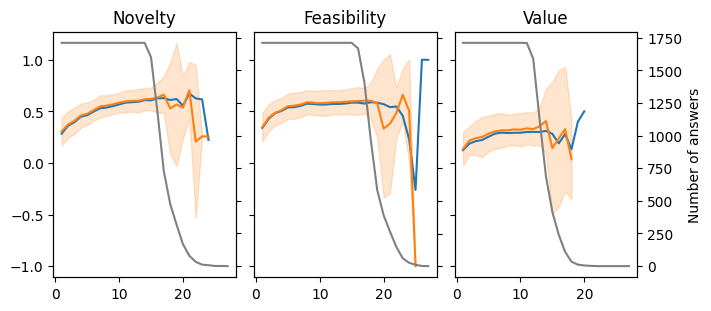

In [22]:
fig, axs = plt.subplots(1, 3, layout='constrained', figsize=(7,3), sharey=True)
for ax, (dim, c) in zip(axs, corr.items()):
    ax.plot(nvals, c)
    ax.plot(nvals, corr_mean[dim])
    ax.fill_between(nvals, corr_mean[dim]-corr_std[dim], corr_mean[dim]+corr_std[dim], color='C1', alpha=.2)
    ax.set_title(dim.capitalize())
    
    ax = ax.twinx()
    ax.plot(nvals, [(elo[dim].N >= n).sum() for n in nvals], color='grey')
    if dim == 'value':
        ax.set_ylabel('Number of answers')
    else:
        ax.set_yticklabels([])

Text(0, 0.5, 'Spearman $\\rho$ (vs. GPT)')

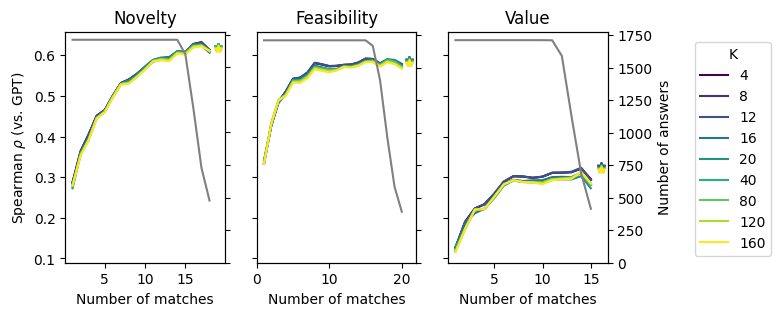

In [23]:
nvals = np.arange(1, max([edim.N.max() for edim in elo.values()]))
fig, axs = plt.subplots(1, 3, figsize=(7,3), sharey=True)
cm = mpl.colormaps['viridis']
for dim, ax in zip(elo, axs):
    if dim == 'value':
        mask = (gpt[dim]>0) & (gpt[dim]<100_000)
    else:
        mask = gpt.index>=0
    cut = nvals < cutoff[dim]
    
    ax.set_title(dim.capitalize())
    ax.set_xlabel('Number of matches')

    for i, (k, ek) in enumerate(zip(k_vals, k_elo)):
        corr = np.full(cut.sum(), np.nan)
        merged = pd.merge(ek[dim], gpt[mask], left_on=['Item', 'Answer'], right_on=['Question id', 'Answer'])
        for n in nvals[cut]:
            if n not in merged:
                break
            subset = merged[merged.N >= n]
            corr[n-1] = stats.spearmanr(subset[n], subset[dim]).statistic
        ax.plot(nvals[cut], corr, c=cm(i / (len(k_vals)-1)), label=k)
        ax.plot(nvals[cut][-1]+1, stats.spearmanr(merged[merged.N.max()], merged[dim]).statistic, '*', c=cm(i / (len(k_vals)-1)))
    
    ax = ax.twinx()
    ax.plot(nvals[cut], [(elo[dim].N >= n).sum() for n in nvals[cut]], color='grey')
    ax.set_ylim(0, None)
    if dim == 'value':
        ax.set_ylabel('Number of answers')
    else:
        ax.set_yticklabels([])

axs[-1].legend(title='K', loc='lower left', bbox_to_anchor=(1.5,0))
axs[0].set_ylabel('Spearman $\\rho$ (vs. GPT)')
# plt.savefig('Figure S13.pdf')

(0.0, 0.7814861255525748)

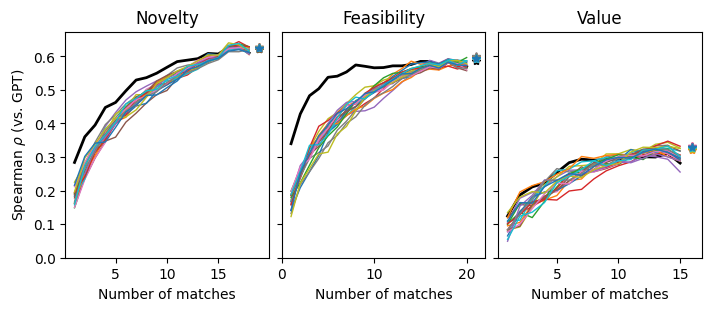

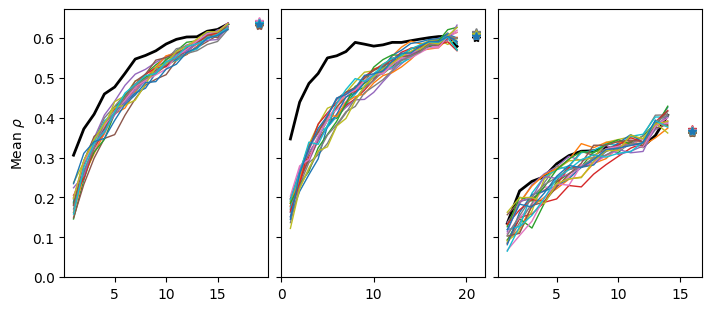

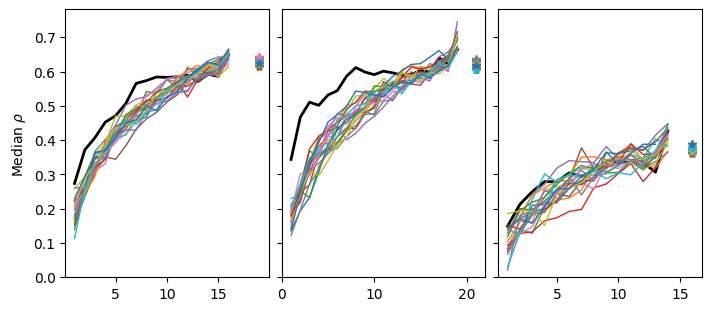

In [24]:
nvals = np.arange(1, max([edim.N.max() for edim in elo.values()]))
fig, axs = plt.subplots(1, 3, figsize=(7,3), sharey=True, layout='constrained')
fig2, axs2 = plt.subplots(1, 3, figsize=(7,3), sharey=True, layout='constrained')
fig3, axs3 = plt.subplots(1, 3, figsize=(7,3), sharey=True, layout='constrained')
for dim, ax, ax2, ax3 in zip(elo, axs, axs2, axs3):
    if dim == 'value':
        mask = (gpt[dim]>0) & (gpt[dim]<100_000)
    else:
        mask = gpt.index>=0
    cut = nvals < cutoff[dim]
    
    ax.set_title(dim.capitalize())
    ax.set_xlabel('Number of matches')

    with warnings.catch_warnings():
        warnings.filterwarnings(action='ignore', category=stats.ConstantInputWarning, message='An input array is constant; the correlation coefficient is not defined.')
        for i, eshuf in enumerate(shuf_elo):
            corr, corr_mean, corr_median = np.full((3, cut.sum()), np.nan)
            merged = pd.merge(eshuf[dim], gpt[mask], left_on=['Item', 'Answer'], right_on=['Question id', 'Answer'])
            for n in nvals[cut]:
                if n not in merged:
                    break
                subset = merged[merged.N >= n]
                corr[n-1] = stats.spearmanr(subset[n], subset[dim]).statistic
                corr_qid = [stats.spearmanr(subset[subset.Item==i][n], subset[subset.Item==i][dim]).statistic for i in subset.Item.unique()]
                corr_mean[n-1] = np.mean(corr_qid)
                corr_median[n-1] = np.median(corr_qid)
            ax.plot(nvals[cut], corr, lw=2 if i==0 else 1, c='k' if i==0 else f'C{i%10}')
            ax2.plot(nvals[cut], corr_mean, lw=2 if i==0 else 1, c='k' if i==0 else f'C{i%10}')
            ax3.plot(nvals[cut], corr_median, lw=2 if i==0 else 1, c='k' if i==0 else f'C{i%10}')

            ax.plot(nvals[cut][-1]+1, stats.spearmanr(merged[merged.N.max()], merged[dim]).statistic, '*', c='k' if i==0 else f'C{i%10}')
            corr_qid = [stats.spearmanr(merged[merged.Item==i][merged.N.max()], merged[merged.Item==i][dim]).statistic for i in merged.Item.unique()]
            ax2.plot(nvals[cut][-1]+1, np.mean(corr_qid), '*', c='k' if i==0 else f'C{i%10}')
            ax3.plot(nvals[cut][-1]+1, np.median(corr_qid), '*', c='k' if i==0 else f'C{i%10}')
axs[0].set_ylabel('Spearman $\\rho$ (vs. GPT)')
axs[0].set_ylim(0, None)
# fig.savefig('Figure S14.pdf')
axs2[0].set_ylabel('Mean $\\rho$')
axs2[0].set_ylim(0, None)
axs3[0].set_ylabel('Median $\\rho$')
axs3[0].set_ylim(0, None)

(0.0, 1.0154643129146328)

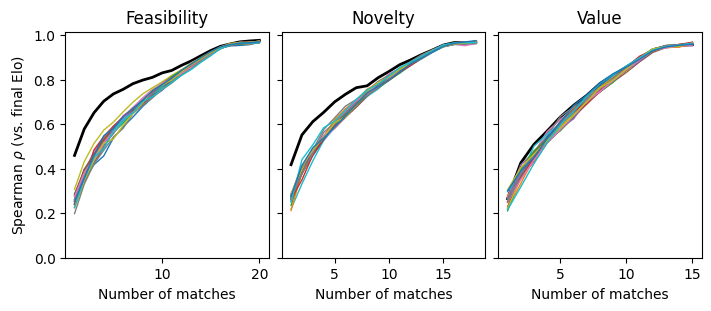

In [14]:
nvals = np.arange(1, max([edim.N.max() for edim in elo.values()]))
fig, axs = plt.subplots(1, 3, figsize=(7,3), sharey=True, layout='constrained')
for dim, ax in zip(elo, axs):
    if dim == 'value':
        mask = (gpt[dim]>0) & (gpt[dim]<100_000)
    else:
        mask = gpt.index>=0
    cut = nvals < cutoff[dim]
    
    ax.set_title(dim.capitalize())
    ax.set_xlabel('Number of matches')

    for i, eshuf in enumerate(shuf_elo):
        corr = np.full(cut.sum(), np.nan)
        merged = pd.merge(eshuf[dim], gpt[mask], left_on=['Item', 'Answer'], right_on=['Question id', 'Answer'])
        for n in nvals[cut]:
            if n not in merged:
                break
            subset = merged[merged.N >= n]
            corr[n-1] = stats.spearmanr(subset[n], subset[eshuf[dim].N.max()]).statistic
        ax.plot(nvals[cut], corr, lw=2 if i==0 else 1, c='k' if i==0 else f'C{i%10}')
axs[0].set_ylabel('Spearman $\\rho$ (vs. final Elo)')
axs[0].set_ylim(0, None)

(0.0, 0.9952284521676867)

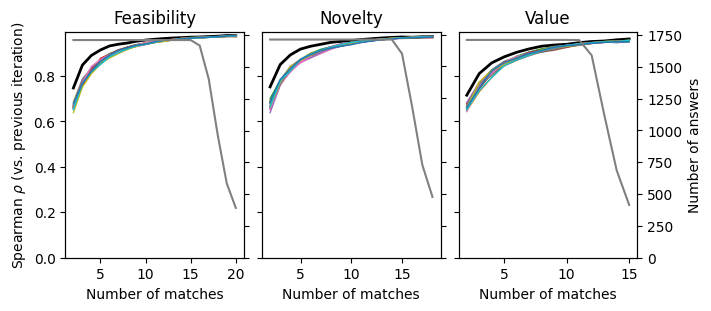

In [16]:
nvals = np.arange(1, max([edim.N.max() for edim in elo.values()]))
fig, axs = plt.subplots(1, 3, figsize=(7,3), sharey=True, layout='constrained')
for dim, ax in zip(elo, axs):
    if dim == 'value':
        mask = (gpt[dim]>0) & (gpt[dim]<100_000)
    else:
        mask = gpt.index>=0
    cut = nvals < cutoff[dim]
    cut[0] = False
    
    ax.set_title(dim.capitalize())
    ax.set_xlabel('Number of matches')
    for i, eshuf in enumerate(shuf_elo):
        merged = pd.merge(eshuf[dim], gpt[mask], left_on=['Item', 'Answer'], right_on=['Question id', 'Answer']).sort_values(['Item', 'Answer']).reset_index(drop=True)
        diff_corr = []
        for n in nvals[cut]:
            if n not in merged:
                break
            subset = merged[merged.N >= n]
            diff_corr.append(stats.spearmanr(subset[n-1], subset[n]).statistic)
        diff_corr = np.asarray(diff_corr)
        ax.plot(nvals[cut], diff_corr, lw=2 if i==0 else 1, c='k' if i==0 else f'C{i%10}')
    
    ax = ax.twinx()
    ax.plot(nvals[cut], [(elo[dim].N >= n).sum() for n in nvals[cut]], color='grey')
    ax.set_ylim(0, None)
    if dim == 'value':
        ax.set_ylabel('Number of answers')
    else:
        ax.set_yticklabels([])

axs[0].set_ylabel('Spearman $\\rho$ (vs. previous iteration)')
axs[0].set_ylim(0, None)

(0.0, 320.03031135531137)

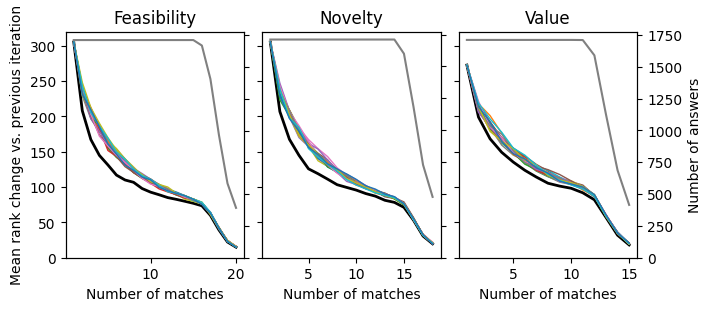

In [17]:
nvals = np.arange(1, max([edim.N.max() for edim in elo.values()]))
fig, axs = plt.subplots(1, 3, figsize=(7,3), sharey=True, layout='constrained')
for dim, ax in zip(elo, axs):
    if dim == 'value':
        mask = (gpt[dim]>0) & (gpt[dim]<100_000)
    else:
        mask = gpt.index>=0
    cut = nvals < cutoff[dim]
    
    ax.set_title(dim.capitalize())
    ax.set_xlabel('Number of matches')
    for i, eshuf in enumerate(shuf_elo):
        rank_changes = []
        merged = pd.merge(eshuf[dim], gpt[mask], left_on=['Item', 'Answer'], right_on=['Question id', 'Answer']).sort_values(['Item', 'Answer']).reset_index(drop=True)
        for n in nvals[cut]:
            if n not in merged:
                break
            subset = merged[merged.N >= n]
            previous_position = subset[n-1].rank(method='average')
            latest_position = subset[n].rank(method='average')
            rank_changes.append(np.mean(np.abs(previous_position - latest_position)))
        rank_changes = np.asarray(rank_changes)
        ax.plot(nvals[cut], rank_changes, lw=2 if i==0 else 1, c='k' if i==0 else f'C{i%10}')
    
    ax = ax.twinx()
    ax.plot(nvals[cut], [(elo[dim].N >= n).sum() for n in nvals[cut]], color='grey')
    ax.set_ylim(0, None)
    if dim == 'value':
        ax.set_ylabel('Number of answers')
    else:
        ax.set_yticklabels([])

axs[0].set_ylabel('Mean rank change vs. previous iteration')
axs[0].set_ylim(0, None)

In [27]:
nvals = np.arange(1, max([edim.N.max() for edim in resample_elo[0].values()]))
cutoff = get_occurrence_cutoffs(resample_elo[0])

(0.0, 0.6822185685616338)

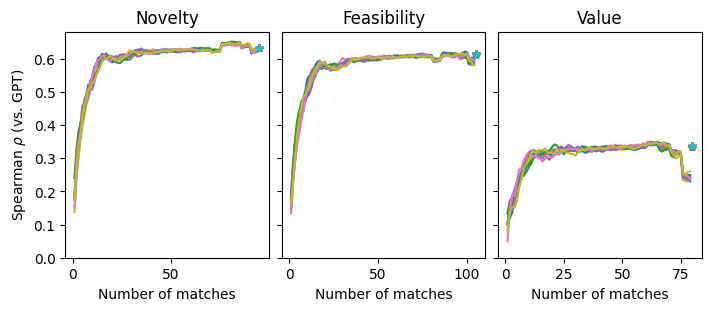

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(7,3), sharey=True, layout='constrained')
for dim, ax in zip(elo, axs):
    if dim == 'value':
        mask = (gpt[dim]>0) & (gpt[dim]<100_000)
    else:
        mask = gpt.index>=0
    cut = nvals < cutoff[dim]
    
    ax.set_title(dim.capitalize())
    ax.set_xlabel('Number of matches')

    for i, eshuf in enumerate(resample_elo):
        corr = np.full(cut.sum(), np.nan)
        merged = pd.merge(eshuf[dim], gpt[mask], left_on=['Item', 'Answer'], right_on=['Question id', 'Answer'])
        for n in nvals[cut]:
            if n not in merged:
                break
            subset = merged[merged.N >= n]
            corr[n-1] = stats.spearmanr(subset[n], subset[dim]).statistic
        ax.plot(nvals[cut], corr)

        ax.plot(nvals[cut][-1]+1, stats.spearmanr(merged[merged.N.max()], merged[dim]).statistic, '*')
axs[0].set_ylabel('Spearman $\\rho$ (vs. GPT)')
axs[0].set_ylim(0, None)

(0.0, 1.0338942158275848)

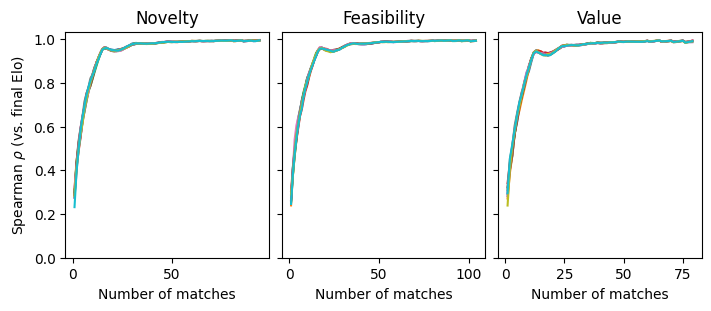

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(7,3), sharey=True, layout='constrained')
for dim, ax in zip(elo, axs):
    if dim == 'value':
        mask = (gpt[dim]>0) & (gpt[dim]<100_000)
    else:
        mask = gpt.index>=0
    cut = nvals < cutoff[dim]
    
    ax.set_title(dim.capitalize())
    ax.set_xlabel('Number of matches')

    for i, eshuf in enumerate(resample_elo):
        corr = np.full(cut.sum(), np.nan)
        merged = pd.merge(eshuf[dim], gpt[mask], left_on=['Item', 'Answer'], right_on=['Question id', 'Answer'])
        for n in nvals[cut]:
            if n not in merged:
                break
            subset = merged[merged.N >= n]
            corr[n-1] = stats.spearmanr(subset[n], subset[eshuf[dim].N.max()]).statistic
        ax.plot(nvals[cut], corr)
axs[0].set_ylabel('Spearman $\\rho$ (vs. final Elo)')
axs[0].set_ylim(0, None)

(0.0, 1.0162363723725218)

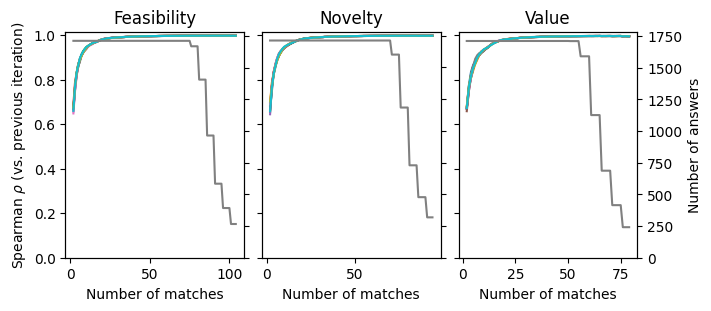

In [106]:
fig, axs = plt.subplots(1, 3, figsize=(7,3), sharey=True, layout='constrained')
for dim, ax in zip(elo, axs):
    if dim == 'value':
        mask = (gpt[dim]>0) & (gpt[dim]<100_000)
    else:
        mask = gpt.index>=0
    cut = nvals < cutoff[dim]
    cut[0] = False
    
    ax.set_title(dim.capitalize())
    ax.set_xlabel('Number of matches')
    for i, eshuf in enumerate(resample_elo):
        merged = pd.merge(eshuf[dim], gpt[mask], left_on=['Item', 'Answer'], right_on=['Question id', 'Answer']).sort_values(['Item', 'Answer']).reset_index(drop=True)
        diff_corr = []
        for n in nvals[cut]:
            if n not in merged:
                break
            subset = merged[merged.N >= n]
            diff_corr.append(stats.spearmanr(subset[n-1], subset[n]).statistic)
        diff_corr = np.asarray(diff_corr)
        ax.plot(nvals[cut], diff_corr)
    
    ax = ax.twinx()
    ax.plot(nvals[cut], [(resample_elo[0][dim].N >= n).sum() for n in nvals[cut]], color='grey')
    ax.set_ylim(0, None)
    if dim == 'value':
        ax.set_ylabel('Number of answers')
    else:
        ax.set_yticklabels([])

axs[0].set_ylabel('Spearman $\\rho$ (vs. previous iteration)')
axs[0].set_ylim(0, None)

In [110]:
for dim in details.Type.unique():
    corr = []
    for eshuf in resample_elo:
        merged = pd.merge(eshuf[dim], elo[dim], on=['Item', 'Answer'], suffixes=('_iterated', '_single'))
        corr.append(stats.spearmanr(merged[f'{merged.N_single.max()}_single'], merged[merged.N_iterated.max()]).statistic)
    print(dim, f'{np.mean(corr):.2f} +- {np.std(corr):.2g}')

novelty 0.98 +- 0.00015
feasibility 0.98 +- 0.00026
value 0.98 +- 0.00018
